
# Business Data Analytics Challenge: Prediction of Electricity Flows

  

Fabio Costa;  Laurin Eichberger;  Nevena Nikolajevic;  Ömer Özumerzifon;  Lukas Petry;  Hendrik Scherner  


---

In [1]:
# Disable all warnings in this notebook to improve readability. 
import warnings
warnings.simplefilter("ignore")

# Plotting
from bda_bokeh import bda_bokeh
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import seaborn as sns

import numpy as np
import pandas as pd

from model.prophet import bda_prophet
from fbprophet import Prophet
import pandas as pd
from datetime import datetime
from keras.utils import plot_model

from keras.models import load_model
import model.cnn_lstm.evaluation as evaluation

Using TensorFlow backend.


---

## 1. Domain Understanding

### Predict the cross-border power flow between Germany and its neighbors

The integration of the European power markets has created a complex system where power is traded depending on a multitude of factors. 

<br>

<img src="img/market integration.png">

<br>

Knowledge about the status of the power market in advance can create **opportunities for power suppliers to profit by managing their capacities**, e.g. because of compensation mechanics like "playing the DEC game" for down-regulations. 
The cross-border energy flows are an important part of understanding the energy trade between countries. 
The goal of this project is to develop a ML-based model that can reliably perform the predictions of the cross-border flows based on publicly available data input.  
 

#### Output requirements of the model:   
Output a 24-hour forecast for the net electricity flow per country using only data that was available before the start of the predicted day:

|     Datetime     | Prediction |
|:----------------:|------------|
| 2019-05-01 00:00 |     786    |
| 2019-05-01 01:00 |     467    |
|        ...       |     ...    |
| 2019-05-01 23:00 |    -230    |


The model is not trained again before the input of future data and shall therefore be generalizable. In this example all data before 2019-05-01 00:00 can be used as *input*, but not for training.  
Quality indicator of the prediction is quantity-weighted RSME. 

<br>

<img src="img/error.png" width="400px">

<br>

### Possible Influences 

A number of possible influences concerning the net export are listed below. Every leaf of the tree is a possible input factor, provided public data is available.

<br>

<img src="img/mindmap_schick.png">

<br>

----

## 2. Data Gathering

### Machine Learning Pipeline

<br>

<img src="img/Struktur_v2.png">

<br>

### Data sources

We found the following data to be publicly available: 

<br>

<img src="img/Sources_v2.png">

<br>

Weather Data:

* 24 weather stations **Germany**
    * Sun hours / Precipitation / 
* 1 weather station for **Denmark**
    * Sun hours / Wind
* Bordeaux for **France**
    * Temperature / Wind Speed
* Prag for **CSZ**
    * Temperature / Wind Speed



<br>

Abbreviations:
```
DWD (German Meteorological Institute)  
DMI (Danish Meteorological Institute)  
LFBD (Airport Bordeaux)  
LKPR (Airport Prague)  
RTE (Réseau de transport d'électricité)  
CEPS (Czech transmission system provider)  
```

---

## 3. Data Analysis & Preprocessing
   

### 3.1 General Analysis

In [2]:
# Use Bokeh to interactively explore the data. 
df = bda_bokeh.import_data()
df = bda_bokeh.preprocessing(df)
bda_bokeh.show_bokeh(df)

Import File: DE_Physikalischer Stromfluss_201506010000_201706012359_1.csv 
Import File: DE_Physikalischer Stromfluss_201706020000_201906022359_1.csv 


Loading BokehJS ...

INFO:bokeh.io.state:Session output file 'bda_bokeh.html' already exists, will be overwritten.


---

### 3.2 Time Series Analysis

#### 3.2.1  General Process

Iteratively analyze and preprocess the data to create a master dataframe that contains valid, coherent and useful data.
<br>

<img src="img/Preprocessing_v2.png">

<br>

---

#### 3.2.2 Contribution to overall power flow 

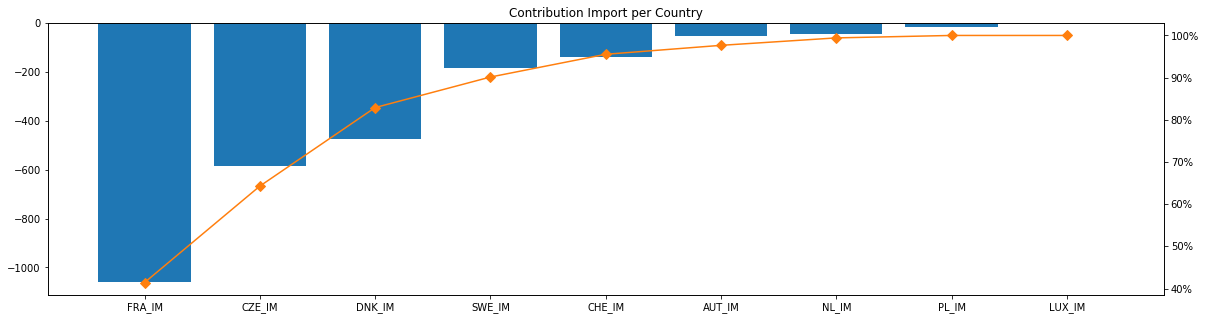

In [3]:
# Understand which countries contribute the most to the overall power flow. 

export_columns = [col for col in df.columns if col[-2::]=='EX' ]
import_columns = [col for col in df.columns if col[-2::]=='IM' ]

import_data = pd.DataFrame(df[import_columns].mean().sort_values(ascending=True),columns=["mean_import"])
import_data['cum_percentage'] = (import_data.cumsum()/import_data.sum())*100

fig, ax = plt.subplots(figsize=[20,5])
ax.bar(import_data.index,import_data.mean_import)
    
ax2 = ax.twinx()
ax.set_title('Contribution Import per Country')

ax2.plot(import_data.index.values,import_data.cum_percentage,color="C1", marker="D", ms=7)

ax2.yaxis.set_major_formatter(PercentFormatter())

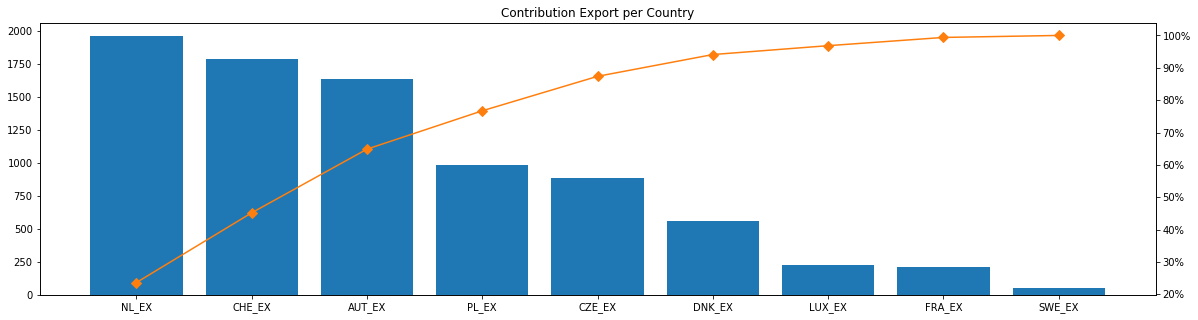

In [4]:
export_data = pd.DataFrame(df[export_columns].mean().sort_values(ascending=False),columns=["mean_import"])
export_data['cum_percentage'] = (export_data.cumsum()/export_data.sum())*100

fig, ax = plt.subplots(figsize=[20,5])

ax.bar(export_data.index,export_data.mean_import)
ax.set_title('Contribution Export per Country')
ax2 = ax.twinx()
ax2.plot(export_data.index.values,export_data.cum_percentage, color="C1", marker="D", ms=7)
ax2.yaxis.set_major_formatter(PercentFormatter())


---

#### 3.2.3 Auto-Correlation ( 1 / 24 Lag )

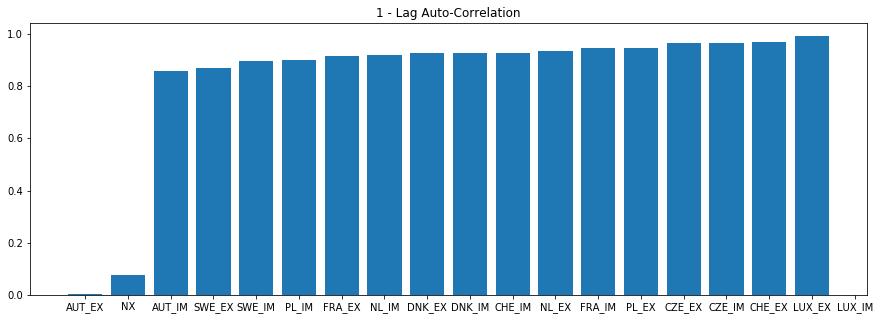

In [5]:
auto_corr = df.loc[:,'NX':'PL_IM'].apply(lambda col: col.autocorr(lag=1) ,axis=0).sort_values()

plt.figure(figsize=[15,5])
plt.title('1 - Lag Auto-Correlation')
plt.bar(auto_corr.index,auto_corr.values)
plt.show()

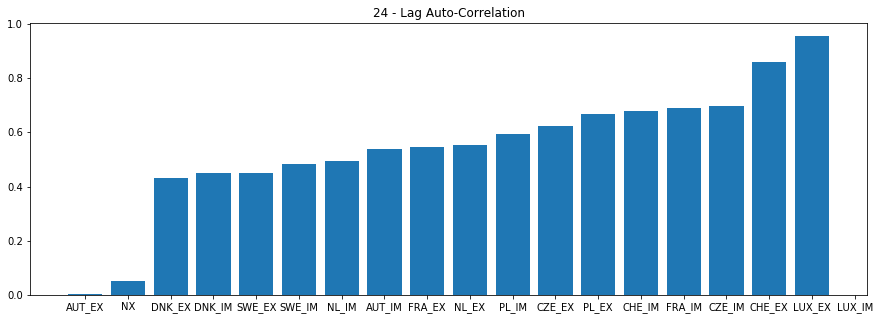

In [6]:
auto_corr = df.loc[:,'NX':'PL_IM'].apply(lambda col: col.autocorr(lag=24) ,axis=0).sort_values()

plt.figure(figsize=[15,5])
plt.title('24 - Lag Auto-Correlation')
plt.bar(auto_corr.index,auto_corr.values)
plt.show()

---

### 3.3 Correlation

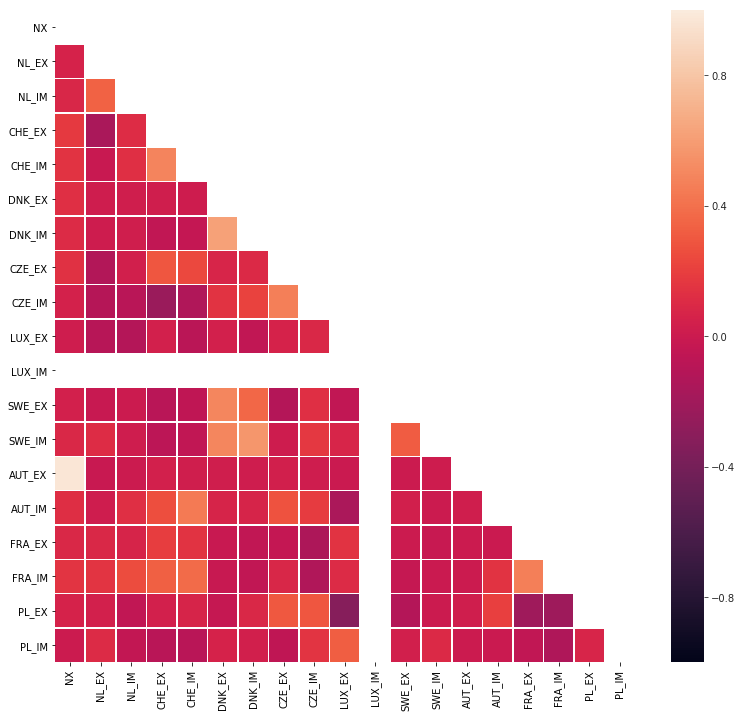

In [7]:
# Check if there are strong correlations between countries. 
fig, ax = plt.subplots()
fig.set_size_inches(13, 12)
mask = np.zeros_like(df.loc[:,'NX':'PL_IM'].corr())
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    sns.heatmap(df.loc[:,'NX':'PL_IM'].corr(),mask=mask,vmin=-1,vmax=1,linewidths=.5)

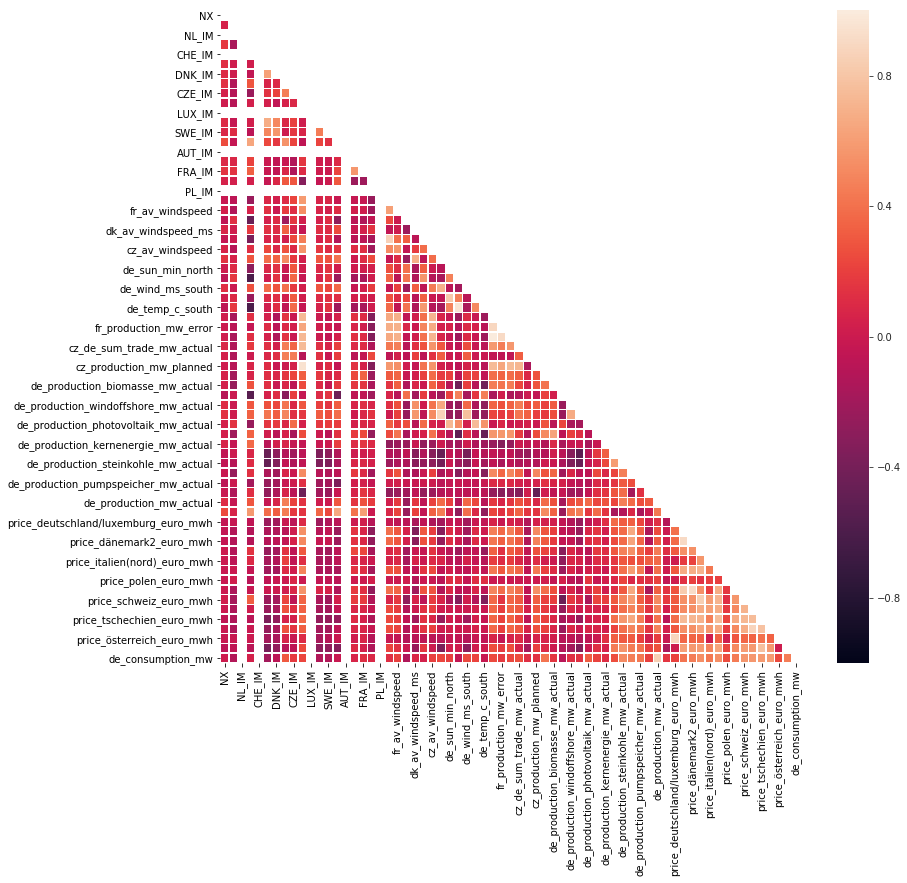

In [8]:
# Check if there are strong correlations between all features. 
df_all_features = pd.read_csv('data/df_all_features.csv',sep=";",index_col=0)

fig, ax = plt.subplots()
fig.set_size_inches(13, 12)
mask = np.zeros_like(df_all_features.loc[:,'NX':'de_consumption_mw'].corr())
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    sns.heatmap(df_all_features.loc[:,'NX':'de_consumption_mw'].corr(),mask=mask,vmin=-1,vmax=1,linewidths=.5)

### Results of Data Analysis and Preprocessing
* There are transport capacities for every border
* The data exhibits high seasonality and low trend
* Import mostly depends on France, Czech Republic and Denmark
* Export mostly depends on the Netherlands, Czech Republic and Austria 
* Strong one-hour auto-correlation

---

## 4. Model

### 4.1 Possible Models

A evaluation of available forecasting methods leads to the following selection of promising candidates.
<br>

<img src="img/possible_models_v6.png" width="900px">

<br>

### 4.2 Auto-Regressive Decomposition Model: FBProphet

A decomposition of linear components with Facebook's Prophet creates additional insights. 

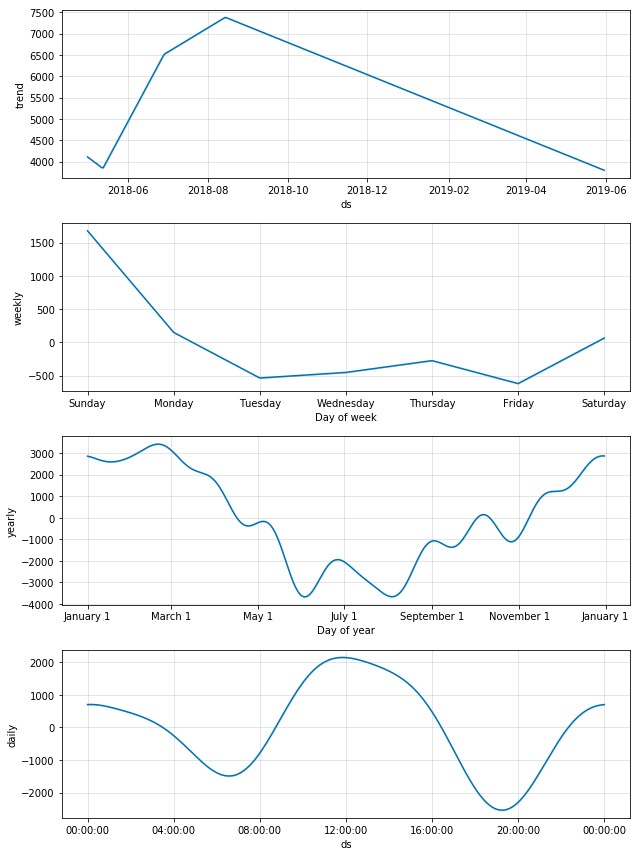

In [9]:
country_codes = bda_prophet.extract_country_codes(df)
df = bda_prophet.get_net_export(df, country_codes, ["EX","IM"])

df_NX = df[['Date', 'NX']]
df_NX = bda_prophet.rename_columns_for_prophet(df_NX)

m = Prophet()
m.fit(df_NX)

future = pd.DataFrame({"ds": pd.date_range(start=datetime(2018,5,1), end=datetime(2019,5,31,23,0,0))})
forecast = m.predict(future) 
fig2 = m.plot_components(forecast)

----

## 4.3 Deep Nets

In [10]:
model = load_model('model/cnn_lstm/cnn_lstm.h5')
plot_model(model, to_file='img/cnn_lstm.png',show_shapes=True,show_layer_names=True)

<br>

<img src="img/cnn_lstm.png">

<br>

---

## 4.4 Model Evaluation and Forecast for May

In [11]:
df_predictions = pd.read_csv('data/df_predictions.csv',sep=";",parse_dates=['Tag'])
df_true_eval_values = pd.read_csv('data/df_true_eval_values.csv',sep=";",parse_dates=['Tag'])
df_predictions = df_predictions.set_index('Tag')
df_true_eval_values = df_true_eval_values.set_index('Tag')

In [12]:
cols = ['NL', 'CHE', 'DNK', 'CZE', 'LUX', 'SWE', 'AUT','FRA', 'PL']
evaluation.calculate_prediction_errors(df_predictions,df_true_eval_values,cols)

Prophet Scaled RSE: 26110.271415103074
Prophet Scaled RMSE: 106.4325506206601
LSTM Scaled RSE: 22051.93704300782
LSTM Scaled RMSE: 89.82924855526691
CNNLSTM Scaled RSE: 19633.210668287604
CNNLSTM Scaled RMSE: 79.97649175307869


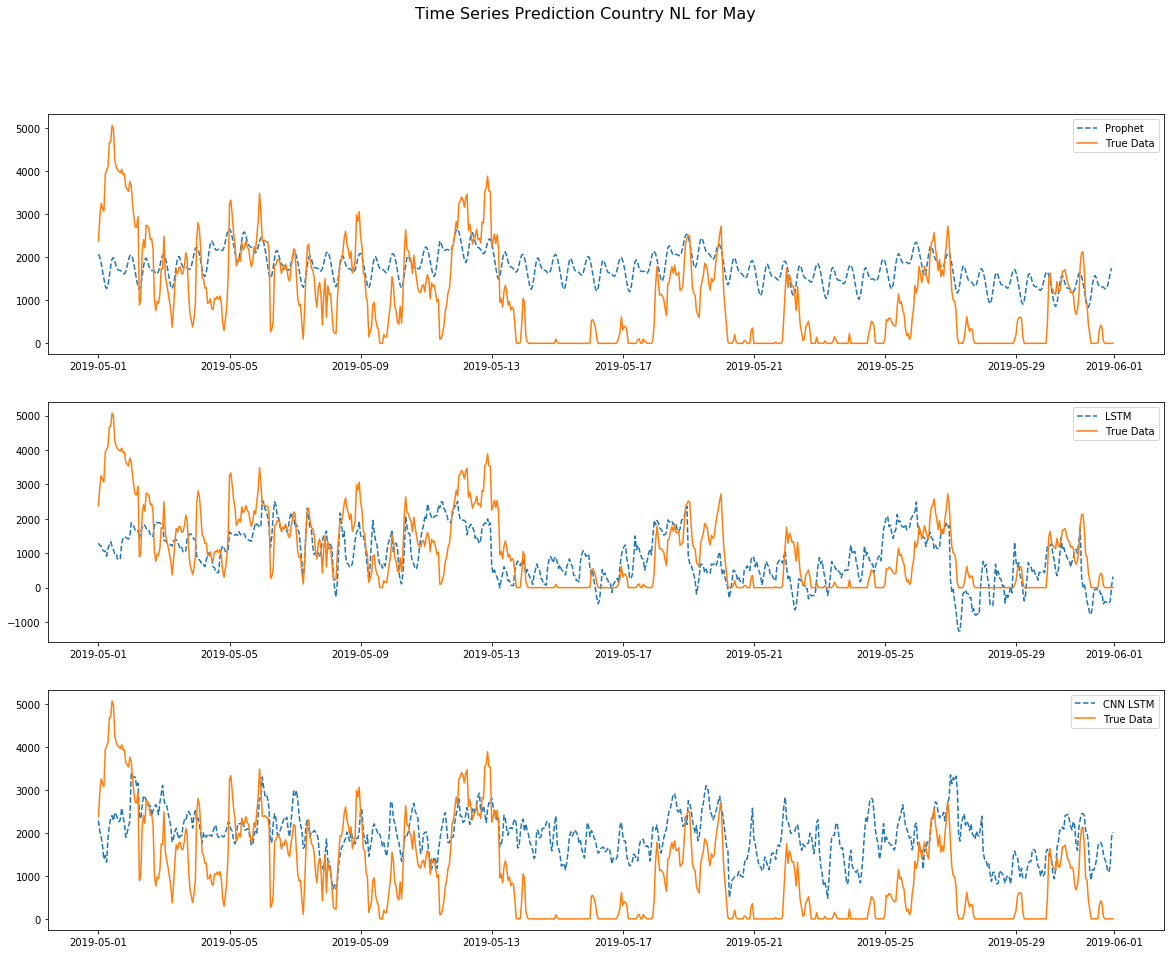

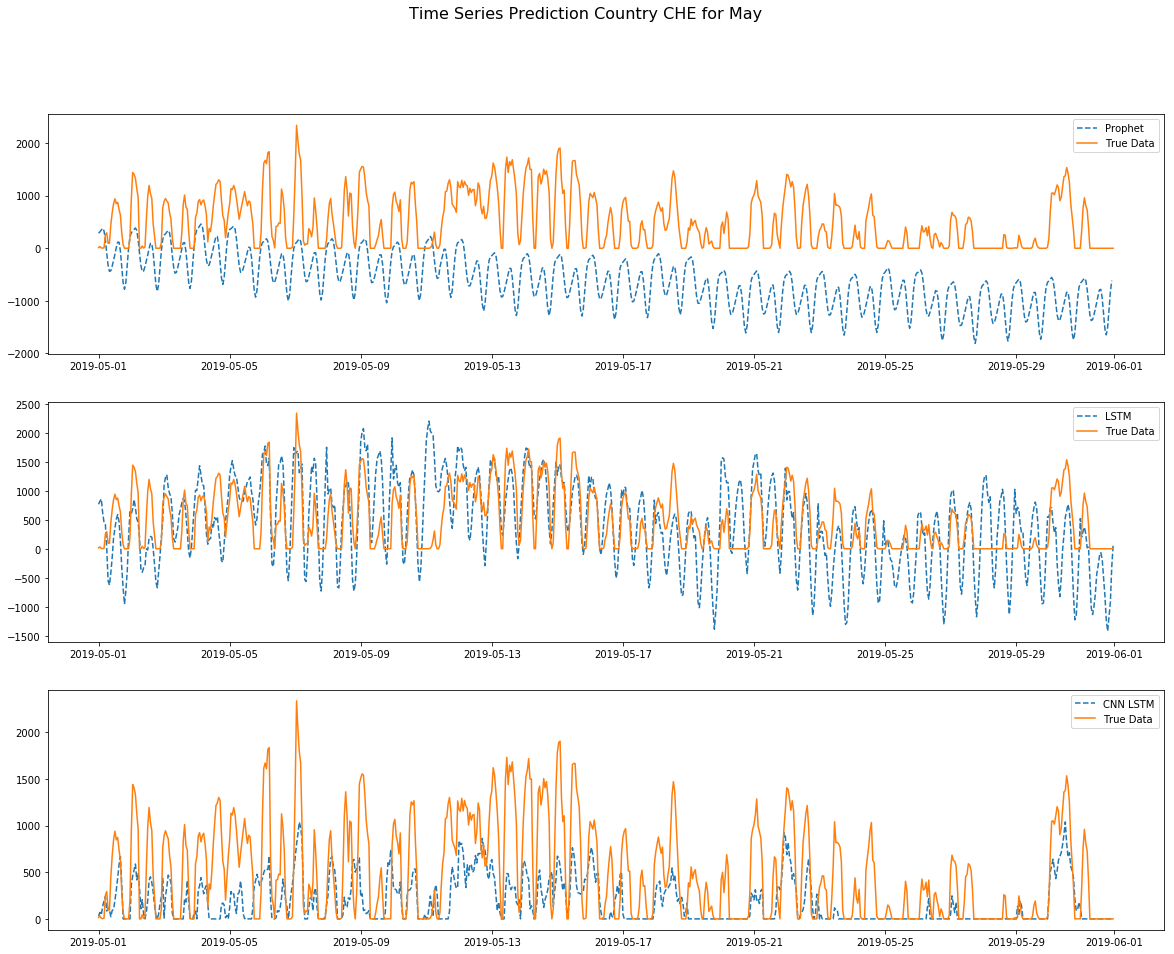

In [ ]:
evaluation.plot_predictions(df_predictions,df_true_eval_values,cols) 

### Results of Model Selection, Training, and Evaluation
* CNN + LSTM produce the best results with an MAE between 74 and 989 depending on the border.
* Autoregressive models can serve as benchmarks for advanced models and create additional insights.
* 3 years of data might not be sufficient enough data points for neural networks.
* Forecast results suggest there are important external factors not yet included in the input data. 
* Manual hyperparameter tuning not feasible due to network complexity.
* Automatic hyperparameter tuning not feasible due to computational resource limitations.

---

## 5. Conclusion

* Success of machine learning projects **depends heavily on available data**. 
* Preprocessing is a costly activity and requires major allocation of project resources and coordination efforts. 
* **Agile project management** is well suited for small machine learning projects, as it facilitates rapid iteration and prototyping.
* LSTMs handle time series data well while requiring a comparatively limited number of nodes and only a simple net topology.
* **LSTMs can be combined with CNNs for feature extraction**, which results in better accuracy, but increases net complexity significantly. 

---

----

By: Lukas Petry, Ömer Özumerzifon, Laruin Eichberger, Fabio Costa, Nevena Nikolajevic, Hendrik Scherner